In [1]:
import torch 
from torch import nn 

In [7]:
import math 
import matplotlib.pyplot as plt 
import torchvision 
import torchvision.transforms as transforms 

In [3]:
device = ""
if torch.cuda.is_available(): 
    device = torch.device('cuda')
else: 
    device = torch.device("cpu")

In [13]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])


In [15]:
train_set = torchvision.datasets.MNIST(root=".", train=True, download=True, transform=transform)

100%|███████████████████████████| 9912422/9912422 [00:00<00:00, 15738401.86it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|█████████████████████████████████| 28881/28881 [00:00<00:00, 380249.47it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|████████████████████████████| 1648877/1648877 [00:00<00:00, 3956647.48it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 1767374.41it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [16]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

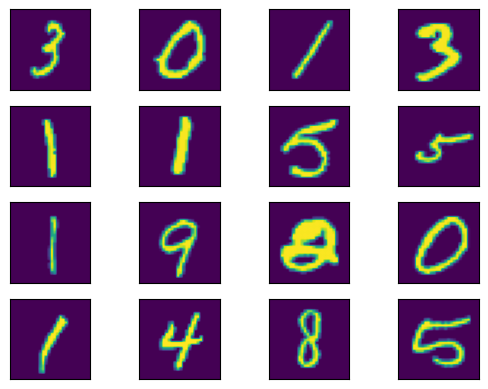

In [18]:
real_samples, mnist_lables = next(iter(train_loader)) 
for i in range(16): 
    ax = plt.subplot(4, 4, i+1) 
    plt.imshow(real_samples[i].reshape(28, 28))
    plt.xticks([])
    plt.yticks([])

In [23]:
class Discriminator(nn.Module):
    def __init__(self): 
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024), 
            nn.ReLU(),
            nn.Dropout(0.3), 
            nn.Linear(1024, 512), 
            nn.ReLU(), 
            nn.Dropout(0.3),
            nn.Linear(512, 256), 
            nn.ReLU(), 
            nn.Dropout(0.3), 
            nn.Linear(256, 1), 
            nn.Sigmoid(), 
        )

    def forward(self, x): 
        x = x.view(x.size(0), 784) 
        output = self.model(x) 
        return output 

In [21]:
class Generator(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256), 
            nn.ReLU(), 
            nn.Linear(256, 512), 
            nn.ReLU(), 
            nn.Linear(512, 1024), 
            nn.ReLU(), 
            nn.Linear(1024, 784), 
            nn.Tanh(), 
        ) 

    def forward(self, x): 
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28) 
        return output 

In [24]:
discriminator = Discriminator().to(device=device)
generator = Generator().to(device=device)

In [25]:
lr = 0.0001
epochs = 50
loss = nn.BCELoss()

In [31]:
discrim_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr) 

In [32]:
gener_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

In [33]:
for epoch in range(epochs): 
    for n, (real_samples, mnist_lables) in enumerate(train_loader): 
    # Data to train the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
        generated_samples = generator(latent_space_samples) 
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device) 
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels)) 
    
        # Train the discriminator 
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        discrim_optimizer.step() 
    
        # Data for training the generator 
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device) 
    
        # Train the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples) 
        output_discriminator_generated = discriminator(generated_samples) 
        loss_generator = loss(output_discriminator_generated, real_samples_labels) 
        loss_generator.backward()
        gener_optimizer.step()
    
        # show less... 
        if n == batch_size - 1: 
            print(f"Epoch: {epoch}  Discriminator Loss: {loss_discriminator}  Generator Loss: {loss_generator}")


Epoch: 0  Discriminator Loss: 0.5924222469329834  Generator Loss: 0.4563904404640198
Epoch: 1  Discriminator Loss: 0.053174231201410294  Generator Loss: 4.3684210777282715
Epoch: 2  Discriminator Loss: 0.0031828528735786676  Generator Loss: 7.153998851776123
Epoch: 3  Discriminator Loss: 0.006998885422945023  Generator Loss: 8.077553749084473
Epoch: 4  Discriminator Loss: 0.014299670234322548  Generator Loss: 4.2484049797058105
Epoch: 5  Discriminator Loss: 0.03946894034743309  Generator Loss: 4.819694519042969
Epoch: 6  Discriminator Loss: 0.014480133540928364  Generator Loss: 6.581687927246094
Epoch: 7  Discriminator Loss: 0.07889733463525772  Generator Loss: 4.216207504272461
Epoch: 8  Discriminator Loss: 0.15304696559906006  Generator Loss: 3.053553342819214
Epoch: 9  Discriminator Loss: 0.17906606197357178  Generator Loss: 2.757206916809082
Epoch: 10  Discriminator Loss: 0.1199660524725914  Generator Loss: 2.88667631149292
Epoch: 11  Discriminator Loss: 0.22375929355621338  Genera

KeyboardInterrupt: 

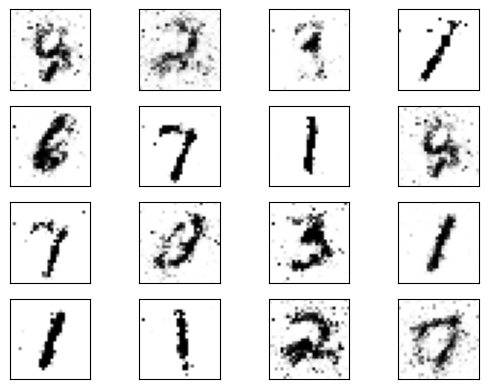

In [34]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [ ]:
import warnings
warnings.filterwarnings('ignore')


Epoch [0/50]: 100%|█| 1875/1875 [00:34<00:00, 54.66it/s, disc_loss=0.58, gen_los


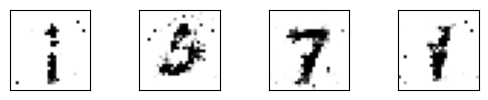

Epoch [1/50]: 100%|█| 1875/1875 [00:34<00:00, 53.80it/s, disc_loss=0.419, gen_lo


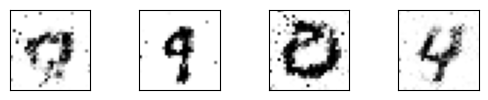

Epoch [2/50]: 100%|█| 1875/1875 [00:36<00:00, 51.63it/s, disc_loss=0.474, gen_lo


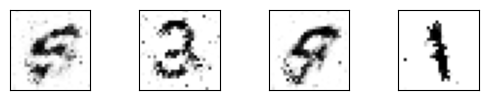

Epoch [3/50]: 100%|█| 1875/1875 [00:34<00:00, 54.26it/s, disc_loss=0.457, gen_lo


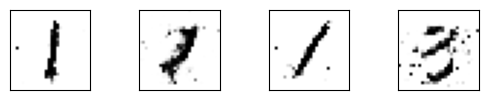

Epoch [4/50]: 100%|█| 1875/1875 [00:32<00:00, 57.09it/s, disc_loss=0.444, gen_lo


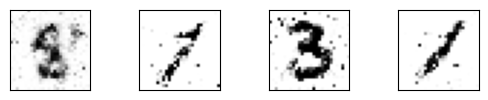

Epoch [5/50]: 100%|█| 1875/1875 [00:34<00:00, 54.85it/s, disc_loss=0.514, gen_lo


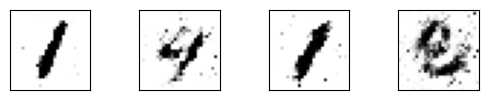

Epoch [6/50]: 100%|█| 1875/1875 [00:34<00:00, 54.22it/s, disc_loss=0.541, gen_lo


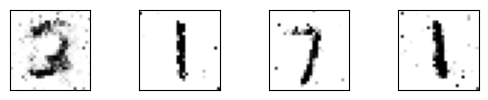

Epoch [7/50]: 100%|█| 1875/1875 [00:34<00:00, 54.88it/s, disc_loss=0.464, gen_lo


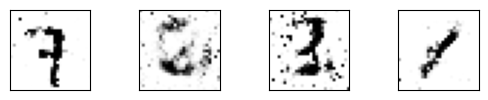

Epoch [8/50]: 100%|█| 1875/1875 [00:36<00:00, 51.46it/s, disc_loss=0.583, gen_lo


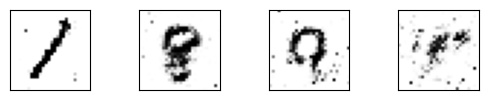

Epoch [9/50]: 100%|█| 1875/1875 [00:34<00:00, 53.66it/s, disc_loss=0.498, gen_lo


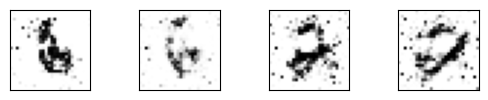

Epoch [10/50]: 100%|█| 1875/1875 [00:34<00:00, 53.83it/s, disc_loss=0.543, gen


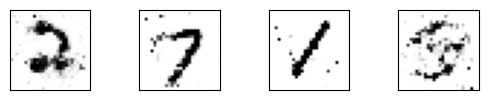

Epoch [11/50]: 100%|█| 1875/1875 [00:34<00:00, 54.25it/s, disc_loss=0.573, gen


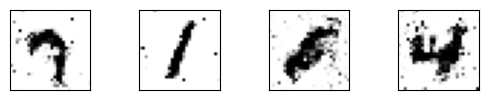

Epoch [12/50]: 100%|█| 1875/1875 [00:35<00:00, 53.28it/s, disc_loss=0.517, gen


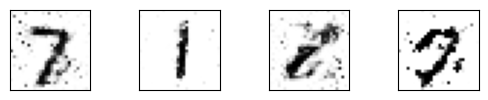

Epoch [13/50]: 100%|█| 1875/1875 [00:34<00:00, 54.59it/s, disc_loss=0.519, gen


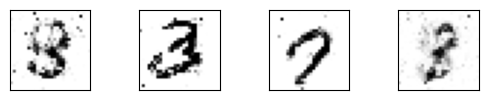

Epoch [14/50]: 100%|█| 1875/1875 [00:34<00:00, 53.80it/s, disc_loss=0.575, gen_l


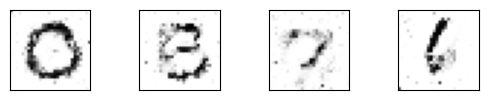

Epoch [15/50]: 100%|█| 1875/1875 [00:34<00:00, 54.23it/s, disc_loss=0.631, gen_l


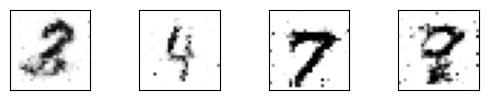

Epoch [16/50]: 100%|█| 1875/1875 [00:34<00:00, 54.22it/s, disc_loss=0.55, gen_lo


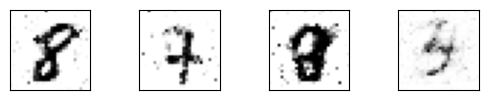

Epoch [17/50]: 100%|█| 1875/1875 [00:33<00:00, 55.47it/s, disc_loss=0.559, gen_l


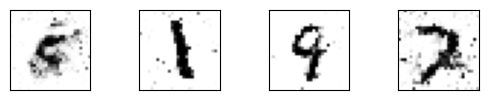

Epoch [18/50]: 100%|█| 1875/1875 [00:33<00:00, 55.44it/s, disc_loss=0.596, gen_l


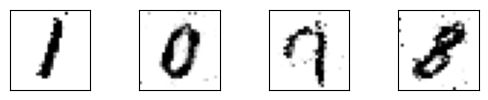

Epoch [19/50]: 100%|█| 1875/1875 [00:32<00:00, 56.98it/s, disc_loss=0.592, gen_l


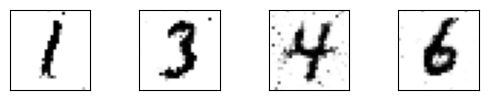

Epoch [20/50]: 100%|█| 1875/1875 [00:33<00:00, 56.56it/s, disc_loss=0.535, gen_l


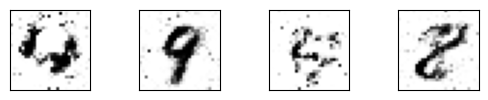

Epoch [21/50]: 100%|█| 1875/1875 [00:33<00:00, 55.94it/s, disc_loss=0.471, gen_l


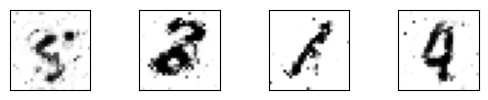

Epoch [22/50]: 100%|█| 1875/1875 [00:33<00:00, 56.49it/s, disc_loss=0.556, gen_l


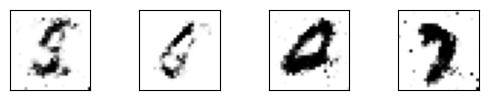

Epoch [23/50]: 100%|█| 1875/1875 [00:32<00:00, 58.06it/s, disc_loss=0.556, gen_l


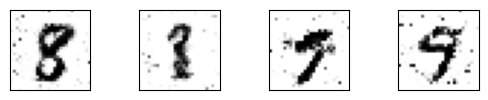

Epoch [24/50]:  20%|▏| 370/1875 [00:06<00:27, 55.69it/s, disc_loss=0.517, gen_lo

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Assuming 'epochs' is defined
# Assuming 'train_loader' is defined
# Assuming 'device', 'generator', 'discriminator', 'loss', 'discrim_optimizer', 'gener_optimizer' are all defined
# Assuming 'batch_size' is defined

for epoch in range(epochs):
    # Initialize tqdm progress bar
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)

    for n, (real_samples, mnist_labels) in loop:
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Train the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        discrim_optimizer.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

        # Train the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        gener_optimizer.step()

        # Update progress bar
        loop.set_description(f"Epoch [{epoch}/{epochs}]")
        loop.set_postfix(discr_loss=loss_discriminator.item(), gen_loss=loss_generator.item())

    # Display generated image after each epoch
    # Generate images for visualization
    with torch.no_grad():
        # Generate a batch of images
        test_latent_space_samples = torch.randn(batch_size, 100).to(device=device)
        generated_images = generator(test_latent_space_samples).cpu().detach()
    
    # Convert the first image in the batch to displayable format
    generated_samples = generated_samples.cpu().detach()
    for i in range(4):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
        plt.xticks([])
        plt.yticks([])
    plt.show()
